In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [20]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator
from qiskit.quantum_info import partial_trace as partial_trace_qiskit
from qiskit.quantum_info import entropy as entropy_qiskit 
from spin import *
import numpy as np
# from trotter import *
import time

In [48]:
simulator_gpu = AerSimulator(method='statevector', device='GPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

['GPU']
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [3]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 24

QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)
# powerlaw = Power_Law(n, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

H = QIMF.ham_xyz
# H = powerlaw.ham_xyz
print(H)

init = Statevector.from_label("10"*int(n/2))
t = 10
r = 100
m = 1
dt = (t / r)
dt2 = (t / (r*m))

print(dt, dt2)

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIIIIXXIIIIIIIII', 'IIIIIIIIIIIIXXIIIIIIIIII', 'IIIIIIIIIIIXXIIIIIIIIIII', 'IIIIIIIIIIXXIIIIIIIIIIII', 'IIIIIIIIIXXIIIIIIIIIIIII', 'IIIIIIIIXXIIIIIIIIIIIIII', 'IIIIIIIXXIIIIIIIIIIIIIII', 'IIIIIIXXIIIIIIIIIIIIIIII', 'IIIIIXXIIIIIIIIIIIIIIIII', 'IIIIXXIIIIIIIIIIIIIIIIII', 'IIIXXIIIIIIIIIIIIIIIIIII', 'IIXXIIIIIIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIIIIIII', 'XXIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIIIIIXIIIIIIIIII', 'IIIIIIIIIIIIXIIIIIIIIIII', 'III

In [4]:
from qiskit.synthesis import SuzukiTrotter

trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())

trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())

start_time = time.time()
data, data2 = [], []
ideal_psi = init
total_steps = r*m - 1

for s in range(1, r+1):
  circ_pf1 = QuantumCircuit(n)
  circ_pf1.set_statevector(ideal_psi.data)
  circ_pf1.append(trotter_step_first_order, range(n))
  circ_pf1.save_statevector(label=f"sv_{s}")

  circ_pf1 = circ_pf1.decompose(reps=2)
  res = simulator_gpu.run(circ_pf1).result()
  psi = res.data(0)[f"sv_{s}"]
  data.append(psi)

  for ss in range (1, m+1):
    # print("step:", ss)
    circ_pf2 = QuantumCircuit(n)
    circ_pf2.set_statevector(ideal_psi.data)

    circ_pf2.append(trotter_step_second_order, range(n))
    circ_pf2 = circ_pf2.decompose(reps=2)

    circ_pf2.save_statevector(label=f"temp_{total_steps}")

    res2 = simulator_gpu.run(circ_pf2).result()
    temp = res2.data(0)[f"temp_{total_steps}"]
    ideal_psi = temp
    # print(f"temp_{ss}")
    total_steps -= 1

  ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
  data2.append(ideal_psi)

  print(np.linalg.norm(ideal_psi - psi))

better_states = data2
states = data

total_time = time.time() - start_time
print("total time", total_time)

0.0888341185419285
0.10610527145658866
0.09950504648150636
0.08145304252997602
0.1020586835280219
0.1340124423968367
0.13549165798733132
0.10525018673030063
0.07326323339409518
0.07520305941012276
0.08818896669502571
0.08562008266122707
0.06990871780702314
0.05886550847045287
0.06531275547938763
0.07523663978562116
0.07641465669163777
0.0729848202239674
0.07481071538561336
0.07957413795410767
0.0795344534418596
0.07689709731898621
0.07799929862194568
0.08054481803642889
0.07964632099961699
0.0773852946819058
0.07791021616017733
0.07981578671676756
0.07970483796695078
0.07745172597490556
0.07482555881743481
0.07295020934726609
0.07238837439544404
0.07330000964369553
0.07455094899221118
0.07438991011323146
0.07252871458133774
0.0706763089218329
0.07047619275977926
0.07153934062300331
0.07250690730264704
0.07293639180996692
0.07324055353273154
0.07366621788136885
0.07409464261144849
0.07451609804559214
0.07502659453529628
0.0753796752502977
0.07508690768633404
0.07408480034025976
0.072916

In [ ]:
circ_pf2.draw()

In [6]:
pip install cupy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
import cupy as cp
from typing import List

def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A

In [23]:
def entropy(rho):
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    entropy = -cp.sum(eigvals * cp.log2(eigvals))
    return entropy.get() 

In [25]:
entropy_list = []
entropy_list2 = []

start_time = time.time()
for s in range(1, r+1):
    state = cp.asarray(states[s-1].data)
    rdm1 = partial_trace((state), list(range(1)), n)
    rdm2 = partial_trace((state), list(range(2)), n)
    rdm3 = partial_trace((state), list(range(3)), n)
    rdm4 = partial_trace((state), list(range(4)), n)
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(s, temp_entropy)

    better = cp.asarray(better_states[s-1].data) 
    rdm12 = partial_trace((better), list(range(1)), n)
    rdm22 = partial_trace((better), list(range(2)), n)
    rdm32 = partial_trace((better), list(range(3)), n)
    rdm42 = partial_trace((better), list(range(4)), n)
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

total_time = time.time() - start_time
print("total time", total_time)

1 [array(0.08057237), array(0.08057237), array(0.08057237), array(0.08057237)]
[array(0.07844017), array(0.07844541), array(0.07844541), array(0.07844541)]
2 [array(0.2307408), array(0.23077508), array(0.23077508), array(0.23077508)]
[array(0.22248427), array(0.22269892), array(0.22269921), array(0.22269921)]
3 [array(0.38112381), array(0.38197305), array(0.38197409), array(0.38197409)]
[array(0.36790408), array(0.36958781), array(0.36959847), array(0.36959847)]
4 [array(0.4941912), array(0.49903902), array(0.49907278), array(0.49907277)]
[array(0.47910064), array(0.48585837), array(0.485966), array(0.48596587)]
5 [array(0.55344649), array(0.5690925), array(0.5693861), array(0.56938574)]
[array(0.53958009), array(0.55828073), array(0.55886195), array(0.55886076)]
6 [array(0.55874229), array(0.59589682), array(0.59727915), array(0.59727637)]
[array(0.54837477), array(0.58951649), array(0.59164522), array(0.59164045)]
7 [array(0.52271198), array(0.59565206), array(0.60013003), array(0.60

In [26]:
import numpy as np
from scipy.linalg import sqrtm

def trotter_error(better_states, states, r, metric):
    errors = []
    
    for i in range (r): 
        b = better_states[i]
        s = states[i]
        if metric == "norm":
            err = np.linalg.norm(b - s) 
    
        elif metric == "infidelity":
            overlap = np.vdot(b, s)
            err = 1 - np.abs(overlap)**2
    
        elif metric == "dm":
            dm_ideal = np.outer(b, b.conj())
            dm_trotter = np.outer(s, s.conj())
            err = np.linalg.norm(dm_ideal - dm_trotter)
    
        elif metric == "trace":
            b = np.outer(b, b.conj())
            s = np.outer(s, s.conj())
            diff = b - s
            sqrt_term = sqrtm(diff.conj().T @ diff)
            err = 0.5 * np.trace(sqrt_term).real

        errors.append(err)
    return errors

In [27]:
t_error = trotter_error(better_states, states, r, "norm")

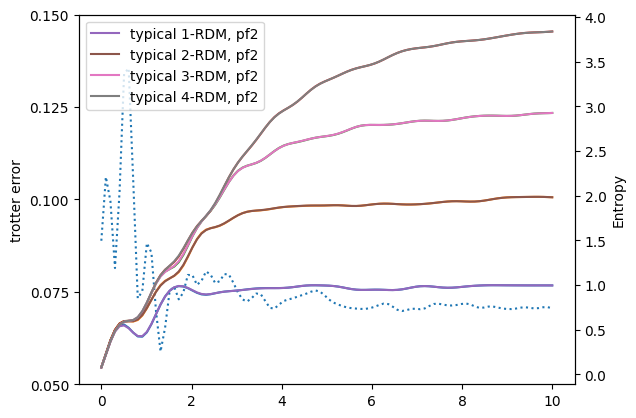

In [28]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]

entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
ax2 = axes.twinx() 
# Create the plot
ax2.plot(times, entropy_values_1)
ax2.plot(times, entropy_values_2)
ax2.plot(times, entropy_values_3)
ax2.plot(times, entropy_values_4) 
ax2.plot(times, entropy_values_12, label='typical 1-RDM, pf2')
ax2.plot(times, entropy_values_22, label='typical 2-RDM, pf2')
ax2.plot(times, entropy_values_32, label='typical 3-RDM, pf2')
ax2.plot(times, entropy_values_42, label='typical 4-RDM, pf2')

axes.plot(times, t_error, linestyle=":") 
y_ticks = [0.05, 0.075, 0.1, 0.125, 0.15] 
axes.set_yticks(y_ticks) 
axes.set_ylabel("trotter error")

ax2.set_xlabel("Time")
ax2.set_ylabel("Entropy")
ax2.legend()

In [19]:
!python --version

Python 3.8.13


In [49]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 22

QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)
# powerlaw = Power_Law(n, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

H = QIMF.ham_xyz
# H = powerlaw.ham_xyz
print(H)

init = Statevector.from_label("10"*int(n/2))
t = 10
r = 100
m = 1
dt = (t / r)
dt2 = (t / (r*m))

print(dt, dt2)

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIIXXIIIIIIIII', 'IIIIIIIIIIXXIIIIIIIIII', 'IIIIIIIIIXXIIIIIIIIIII', 'IIIIIIIIXXIIIIIIIIIIII', 'IIIIIIIXXIIIIIIIIIIIII', 'IIIIIIXXIIIIIIIIIIIIII', 'IIIIIXXIIIIIIIIIIIIIII', 'IIIIXXIIIIIIIIIIIIIIII', 'IIIXXIIIIIIIIIIIIIIIII', 'IIXXIIIIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIIIII', 'XXIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIIIXIIIIIIIIII', 'IIIIIIIIIIXIIIIIIIIIII', 'IIIIIIIIIXIIIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIIII

In [50]:
from qiskit.synthesis import SuzukiTrotter

trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())

trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())

start_time = time.time()
data, data2 = [], []
ideal_psi = init
total_steps = r*m - 1

for s in range(1, r+1):
  circ_pf1 = QuantumCircuit(n)
  circ_pf1.set_statevector(ideal_psi.data)
  circ_pf1.append(trotter_step_first_order, range(n))
  circ_pf1.save_statevector(label=f"sv_{s}")

  circ_pf1 = circ_pf1.decompose(reps=2)
  res = simulator_gpu.run(circ_pf1).result()
  psi = res.data(0)[f"sv_{s}"]
  data.append(psi)

  for ss in range (1, m+1):
    # print("step:", ss)
    circ_pf2 = QuantumCircuit(n)
    circ_pf2.set_statevector(ideal_psi.data)

    circ_pf2.append(trotter_step_second_order, range(n))
    circ_pf2 = circ_pf2.decompose(reps=2)

    circ_pf2.save_statevector(label=f"temp_{total_steps}")

    res2 = simulator_gpu.run(circ_pf2).result()
    temp = res2.data(0)[f"temp_{total_steps}"]
    ideal_psi = temp
    # print(f"temp_{ss}")
    total_steps -= 1

  ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
  data2.append(ideal_psi)

  print(np.linalg.norm(ideal_psi - psi))

better_states = data2
states = data

total_time = time.time() - start_time
print("total time", total_time)

0.08423183701346935
0.09881002360035454
0.0928871417935072
0.07763306786480648
0.09607368036232612
0.12437023965679571
0.12551992755067962
0.0983286846885155
0.06982516044996118
0.07128164589608198
0.08275667283956499
0.08051164537915706
0.06643273624296754
0.056371038869626466
0.061973731141034064
0.07115304664907275
0.07260924133953886
0.06960202021970356
0.0709578417852844
0.07518001148789243
0.07543644282105952
0.07330296484638718
0.07427472938315396
0.07656982309086896
0.07587387223997957
0.07386899183448306
0.0742934099134377
0.07606106683624501
0.07606545525159103
0.07403255726966809
0.07153991701849031
0.06967882764045855
0.06902067655913532
0.06978971019109431
0.07097821362907814
0.07085990795696334
0.06905903811095343
0.06723829224442318
0.06707455267629737
0.06818210524439454
0.06917187524979947
0.06960025241901201
0.06988904042322232
0.07029105499810581
0.07071668649868089
0.07117567934740869
0.07172029127466477
0.07205704251807375
0.07173832592770304
0.07077332418048927
0.

In [51]:
entropy_list = []
entropy_list2 = []

start_time = time.time()
for s in range(1, r+1):
    state = cp.asarray(states[s-1].data)
    rdm1 = partial_trace((state), list(range(1)), n)
    rdm2 = partial_trace((state), list(range(2)), n)
    rdm3 = partial_trace((state), list(range(3)), n)
    rdm4 = partial_trace((state), list(range(4)), n)
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(s, temp_entropy)

    better = cp.asarray(better_states[s-1].data) 
    rdm12 = partial_trace((better), list(range(1)), n)
    rdm22 = partial_trace((better), list(range(2)), n)
    rdm32 = partial_trace((better), list(range(3)), n)
    rdm42 = partial_trace((better), list(range(4)), n)
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

total_time = time.time() - start_time
print("total time", total_time)

1 [array(0.08057237), array(0.08057237), array(0.08057237), array(0.08057237)]
[array(0.07844017), array(0.07844541), array(0.07844541), array(0.07844541)]
2 [array(0.2307408), array(0.23077508), array(0.23077508), array(0.23077508)]
[array(0.22248427), array(0.22269892), array(0.22269921), array(0.22269921)]
3 [array(0.38112381), array(0.38197305), array(0.38197409), array(0.38197409)]
[array(0.36790408), array(0.36958781), array(0.36959847), array(0.36959847)]
4 [array(0.4941912), array(0.49903902), array(0.49907278), array(0.49907277)]
[array(0.47910064), array(0.48585837), array(0.485966), array(0.48596587)]
5 [array(0.55344649), array(0.5690925), array(0.5693861), array(0.56938574)]
[array(0.53958009), array(0.55828073), array(0.55886195), array(0.55886076)]
6 [array(0.55874229), array(0.59589682), array(0.59727915), array(0.59727637)]
[array(0.54837477), array(0.58951649), array(0.59164522), array(0.59164045)]
7 [array(0.52271198), array(0.59565206), array(0.60013003), array(0.60

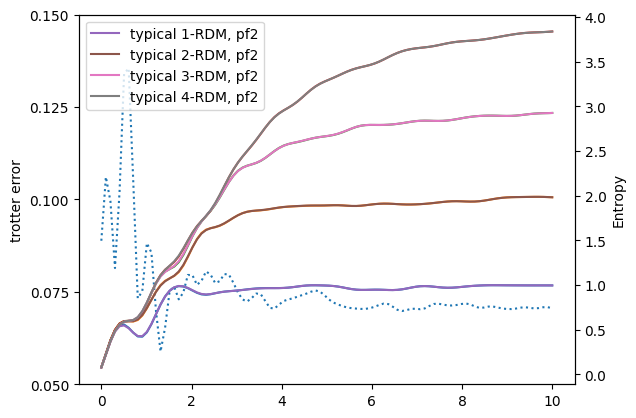

In [52]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]

entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
ax2 = axes.twinx() 
# Create the plot
ax2.plot(times, entropy_values_1)
ax2.plot(times, entropy_values_2)
ax2.plot(times, entropy_values_3)
ax2.plot(times, entropy_values_4) 
ax2.plot(times, entropy_values_12, label='typical 1-RDM, pf2')
ax2.plot(times, entropy_values_22, label='typical 2-RDM, pf2')
ax2.plot(times, entropy_values_32, label='typical 3-RDM, pf2')
ax2.plot(times, entropy_values_42, label='typical 4-RDM, pf2')

axes.plot(times, t_error, linestyle=":") 
y_ticks = [0.05, 0.075, 0.1, 0.125, 0.15] 
axes.set_yticks(y_ticks) 
axes.set_ylabel("trotter error")

ax2.set_xlabel("Time")
ax2.set_ylabel("Entropy")
ax2.legend()